In [ ]:
import os
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.models import load_model

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [ ]:
# Download latest version
path = kagglehub.dataset_download("rupakroy/lstm-datasets-multivariate-univariate")

# load train and test datasets
df_train = pd.read_csv(f"{path}/LSTM-Multivariate_pollution.csv")
df_test = pd.read_csv(f"{path}/pollution_test_data1.csv")

print(df_train)
print(df_train.describe())
print(df_test.describe())


                      date  pollution  dew  temp   press wnd_dir  wnd_spd  \
0      2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79   
1      2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68   
2      2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57   
3      2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36   
4      2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25   
...                    ...        ...  ...   ...     ...     ...      ...   
43795  2014-12-31 19:00:00        8.0  -23  -2.0  1034.0      NW   231.97   
43796  2014-12-31 20:00:00       10.0  -22  -3.0  1034.0      NW   237.78   
43797  2014-12-31 21:00:00       10.0  -22  -3.0  1034.0      NW   242.70   
43798  2014-12-31 22:00:00        8.0  -22  -4.0  1034.0      NW   246.72   
43799  2014-12-31 23:00:00       12.0  -21  -3.0  1034.0      NW   249.85   

       snow  rain  
0         0     0  
1         0     0  
2         0    

In [ ]:
# prepare the data first

# first, map the corresponding classes to integers
mapper = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

df_train['wnd_dir'] = df_train['wnd_dir'].map(mapper)
df_test['wnd_dir'] = df_test['wnd_dir'].map(mapper)
df_train['date'] = pd.to_datetime(df_train['date'])

df_train.set_index('date', inplace = True) # it makes the date column the index of the dataFrame, so each row is labeled by its timestamp instead of a numeric index

In [ ]:
# visualize the data
visualize = False
def plot():
    groups = [1, 2, 3, 5, 6]
    j = 1

    #plot each column
    plt.figure(figsize = (20, 14))

    for i in groups:
        plt.subplot(len(groups), 1, j)
        plt.plot(df_train.values[:, i], color = cm.plasma(i / len(groups)))
        plt.xlabel('Index')
        plt.title(df_train.columns[i], y = 0.75, loc='right', fontsize = 10)

        j +=1

    plt.show()

if visualize:
    plot()

In [ ]:
# data preprocessing
scaler = MinMaxScaler()

# columns to transform
columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir", 'wnd_spd', 'snow', 'rain'])
df_test = df_test[columns]


# scale the selected columns to the range [0, 1]
df_train[columns] = scaler.fit_transform(df_train[columns])
df_test[columns] = scaler.transform(df_test[columns])

# Show the scaled data
df_train.describe()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,0.094581,0.615125,0.515722,0.462678,0.545677,0.040065,0.001954,0.005417
std,0.092809,0.212196,0.199892,0.186753,0.314088,0.085487,0.028170,0.039340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.024145,0.441176,0.344262,0.309091,0.333333,0.002290,0.000000,0.000000
50%,0.068410,0.617647,0.540984,0.454545,0.666667,0.008408,0.000000,0.000000
75%,0.133048,0.808824,0.688525,0.618182,0.666667,0.036674,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# create train, validation and test datasets

df_train = np.array(df_train)
df_test = np.array(df_test)

def make_datasets(df):

    past = 11
    future = 1
    x, y = [], []

    for i in range(past, len(df) - future + 1):

      x.append(df[i - past:i, 1 : df.shape[1]])
      y.append(df[i + future - 1 : i + future, 0])

    return np.array(x), np.array(y)

x_train, y_train = make_datasets(df_train)
x_test, y_test = make_datasets(df_test)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = False)

print(f"x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}")
print(f"x_val.shape: {x_val.shape}, y_val.shape: {y_val.shape}")
print(f"x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}")

x_train.shape: (35031, 11, 7), y_train.shape: (35031, 1)
x_val.shape: (8758, 11, 7), y_val.shape: (8758, 1)
x_test.shape: (335, 11, 7), y_test.shape: (335, 1)


In [ ]:
# build the model

def build_model(x_train):
    model = Sequential()
    model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(16, return_sequences = False))
    model.add(Dense(y_train.shape[1]))

    return model

model = build_model(x_train)
model.compile(loss = "mse", optimizer = Adam(learning_rate = 0.001), metrics = [RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 11, 32)         │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,273 (32.32 KB)

 Trainable params: 8,273 (32.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, epochs = 100, batch_size = 32, validation_data = (x_val, y_val), callbacks = [early_stopping], shuffle = False)

Epoch 1/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0081 - root_mean_squared_error: 0.0896 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1535
Epoch 2/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0295 - val_root_mean_squared_error: 0.1718
Epoch 3/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1688
Epoch 4/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1672
Epoch 5/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1682
Epoch 6/100
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1612
Epoch 7/100
1095/1095 ━━━━━━━━━━━

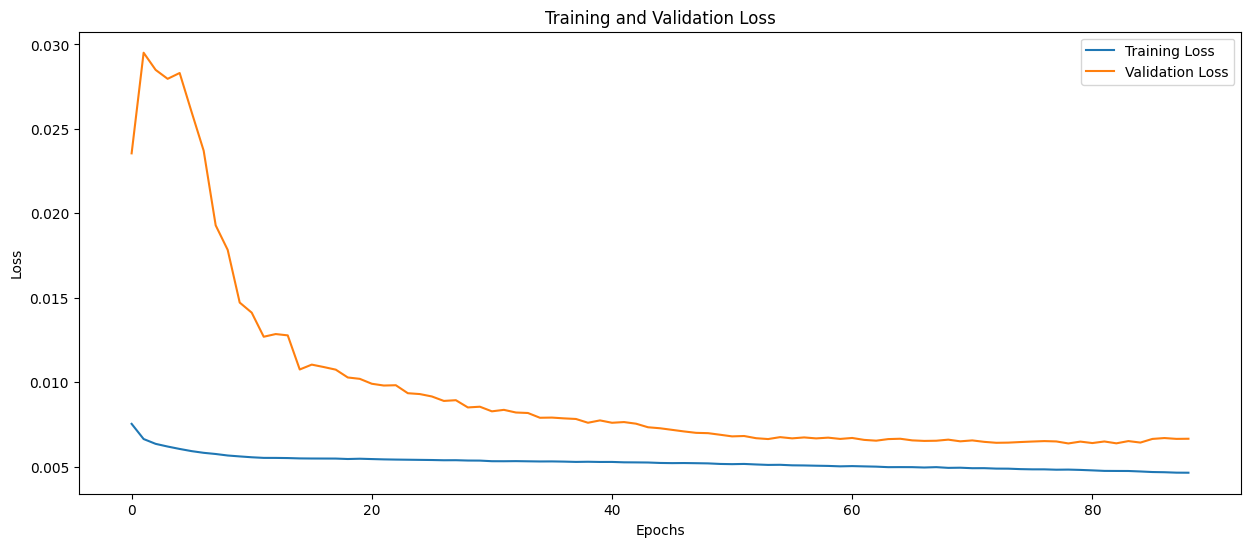

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


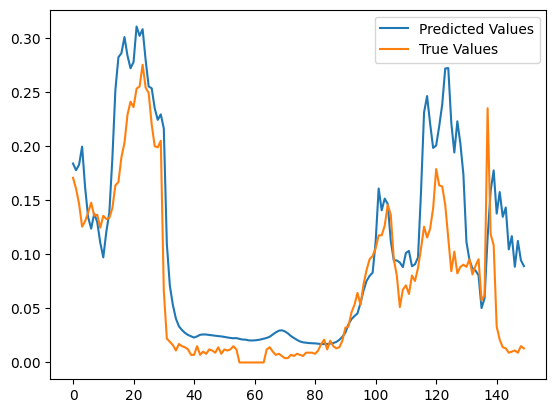

In [ ]:
# plot results

plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# checking the model

test_predictions = model.predict(x_test).flatten()
test_results = pd.DataFrame(data = {'Train Predictions': test_predictions, 'Actual' : y_test.flatten()})

plt.plot(test_results['Train Predictions'][:150], label = 'Predicted Values')
plt.plot(test_results['Actual'][:150], label = 'True Values')
plt.legend()
plt.show()

In [ ]:
# dummy arrays to inverse-transform correctly
# minMaxScaler expects the same number of columns as it was fitted on

y_pred_inv = scaler.inverse_transform( np.concatenate((test_predictions.reshape(-1,1), np.zeros((len(test_predictions), df_train.shape[1]-1))), axis=1))[:,0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test), df_train.shape[1]-1))), axis=1))[:,0]

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("RMSE:", rmse)

RMSE: 69.09821056529915


In [ ]:
# 69.1 / (444 - 0) * 100 = 15.56% NRMSE